# Homework 8

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-20

* Alex Popovici
* alex.popovici@uchicago.edu

In [1]:
from IPython.display import display, Math
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import QuantLib as ql
from scipy.stats import norm, lognorm
from scipy.integrate import quad
from scipy.special import comb
from scipy.optimize import root_scalar
import sympy as sp

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Options Pricing and Volatility Smiles in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

We assume the following input values in the Merton Structural Credit Model
- Initial Assets of 1 (e.g. think about 1 $BN in assets at time 0)
- Face value of Liabilities K: 0.9 (e.g. initial leverage of 90%)
- Bond maturity T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
- Log-normal distribution of assets at time T, using Lecture 7 Formula (27):

$A_{T}=A_{0}\cdot\exp\left[\left(r-\frac{1}{2}\sigma_{A}^{2}\right)\cdot T+\sigma_{A}\cdot W_{T}\right]$


In [3]:
A0 = 1.0                    
K = 0.9                     
T = 5.0                     
sigma_A = 0.20            
r = 0.04         
t = 1.0               
tau = T - t

## a. Distributions of Assets and Equity fair values at time t = 1 year


Use the following discretization grid for Asset at time t: [a from 0.02 to 2 in steps of 0.02].

Compute the density (PDF) and cumulative density (CDF) of Assets at time t.

For each value of the assets, compute the fair value of Equity at time t.

Plot the results: Assets PDF, Assest CDF and Equity fair value at time t.

You can use lognorm from scipy.stats for the log-normal distribution PDF/CFD.

In [4]:
mu_t = np.log(A0) + (r - 0.5 * sigma_A**2) * t
sigma_t = sigma_A * np.sqrt(t)
dist = lognorm(s=sigma_t, scale=np.exp(mu_t))

a_grid = np.linspace(0.02, 2.0, 100) 

pdf_vals = dist.pdf(a_grid)
cdf_vals = dist.cdf(a_grid)

In [5]:
def bs_call_price(S, K, tau, sigma, r):
    if tau <= 0 or sigma <= 0:
        return np.maximum(S - K * np.exp(-r * tau), 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

E_t = bs_call_price(a_grid, K, tau, sigma_A, r)

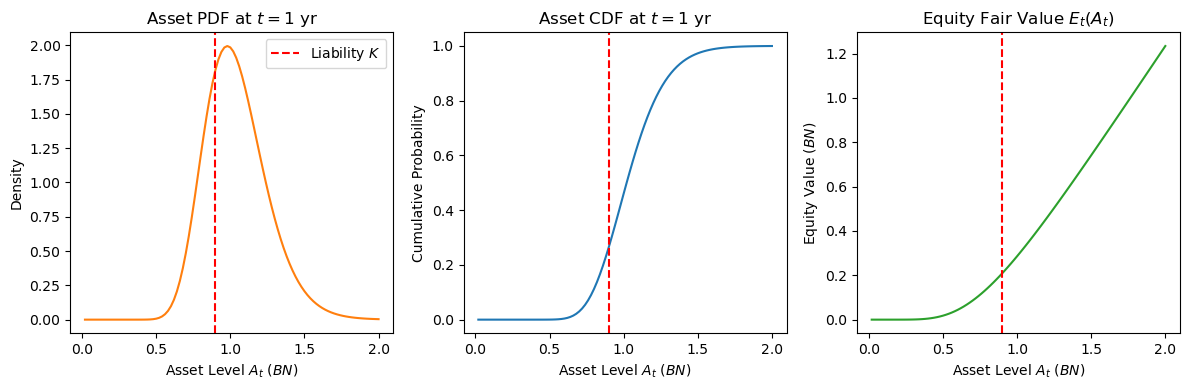

In [6]:
plt.figure(figsize=(12, 4))

# PDF
plt.subplot(1, 3, 1)
plt.plot(a_grid, pdf_vals, color='tab:orange')
plt.axvline(K, color='red', linestyle='--', label='Liability $K$')
plt.title("Asset PDF at $t=1$ yr")
plt.xlabel("Asset Level $A_t$ ($BN$)")
plt.ylabel("Density")
plt.legend()

# CDF
plt.subplot(1, 3, 2)
plt.plot(a_grid, cdf_vals, color='tab:blue')
plt.axvline(K, color='red', linestyle='--')
plt.title("Asset CDF at $t=1$ yr")
plt.xlabel("Asset Level $A_t$ ($BN$)")
plt.ylabel("Cumulative Probability")

# Equity Fair Value
plt.subplot(1, 3, 3)
plt.plot(a_grid, E_t, color='tab:green')
plt.axvline(K, color='red', linestyle='--')
plt.title("Equity Fair Value $E_t(A_t)$")
plt.xlabel("Asset Level $A_t$ ($BN$)")
plt.ylabel("Equity Value ($BN$)")

plt.tight_layout()
plt.show()

## b. Compute the value of an Europen ATM (At-The-Money) Call option with maturity t = 1 year.

For ATM options, the strike k equals the equity value at time 0, i.e. $k = E_0$.

The Call Option value can be obtained by numerical integration of the call payoff function against the log-normal density of A_t, as derived in Lecture 7 formula (47).

You can use quad from scipy.integrate for numerical integration.

$EquityCall\left(E_{0},k,t\right)=e^{-r\cdot t}\cdot\mathbb{E}\left[\left(E_{t}-k\right)^{+}|\mathcal{F}_{0}\right]$

$=e^{-r\cdot t}\cdot\mathbb{E}\left[\left(Call\left(A_{t},K,T-t,\sigma_{A},r,\right)-k\right)^{+}|\mathcal{F}_{0}\right]$

$=\int_{-\infty}^{\infty}e^{-r\cdot t}\cdot\left(Call\left(x,K,T-t,\sigma_{A},r,\right)-k\right)^{+} \cdot \phi_{A_{t}} \, dx$

In [7]:
E0 = bs_call_price(A0, K, T, sigma_A, r)

lower_bound = dist.ppf(1e-6)
upper_bound = dist.ppf(1 - 1e-6)

def equity_call_integrand(a, strike):
    payoff = np.maximum(bs_call_price(a, K, tau, sigma_A, r) - strike, 0.0)
    return np.exp(-r * t) * payoff * dist.pdf(a)

atm_price, atm_err = quad(
    equity_call_integrand, lower_bound, upper_bound,
    args=(E0,), epsabs=1e-9, epsrel=1e-9
)

print(f"E0 (initial equity): {E0:.6f}")
print(f"ATM Equity Call Price: {atm_price:.6f} (error ∼{atm_err:.2e})")

E0 (initial equity): 0.318822
ATM Equity Call Price: 0.071401 (error ∼2.22e-11)


## c. Compute the Implied Volatility of the ATM European Call Option

Implement a function to compute the Implied Volatility in the Black-Scholes model (using European Call option price as input)

Compute the Implied Volatility of the ATM European Call Option.

Use a numerical root finder, e.g. root_scalar from scipy.optimize.

In [8]:
def bs_diff(sigma):
    return bs_call_price(E0, E0, t, sigma, r) - atm_price

sig_lo, sig_hi = 1e-6, 5.0
assert bs_diff(sig_lo) * bs_diff(sig_hi) < 0, "Bracket does not enclose root!"

try:
    sol = root_scalar(bs_diff, bracket=[sig_lo, sig_hi], method='brentq')
    iv_atm = sol.root
    print(f"ATM Implied Volatility: {iv_atm:.4%}")
except Exception as e:
    print("Implied vol solver error:", e)

ATM Implied Volatility: 52.7039%


## d. Plot the option Implied Volatility Smile in the Merton model

Use a grid of strikes [k from 80% to 120% in steps of 5%], relative to the spot equity price E_0.

Compute the European Call options prices and the corresponding option Implied Volatilities on the above grid.
Plot the Implied Volatility smile (Implied Volatities by strikes).

In [9]:
rel_strikes = np.arange(0.8, 1.201, 0.05)
k_grid = rel_strikes * E0
ivs = []

for k_i in k_grid:
    price_i, _ = quad(
        equity_call_integrand, lower_bound, upper_bound,
        args=(k_i,), epsabs=1e-9, epsrel=1e-9
    )
    def diff_iv(sig): return bs_call_price(E0, k_i, t, sig, r) - price_i
    if diff_iv(sig_lo)*diff_iv(sig_hi) >= 0:
        ivs.append(np.nan)
    else:
        try:
            ivs.append(root_scalar(diff_iv, bracket=[sig_lo, sig_hi], method='brentq').root)
        except:
            ivs.append(np.nan)

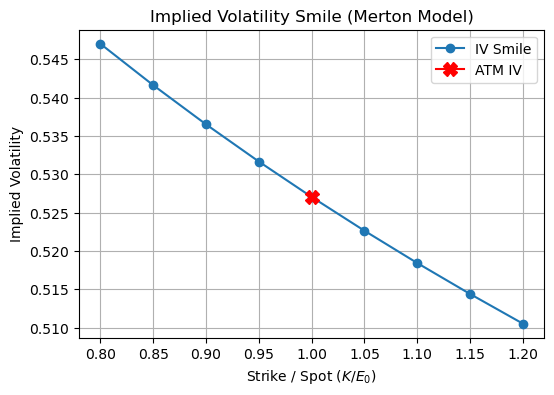

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(rel_strikes, ivs, marker='o', label='IV Smile')
plt.plot(1.0, iv_atm, marker='X', markersize=10, color='red', label='ATM IV')
plt.title("Implied Volatility Smile (Merton Model)")
plt.xlabel("Strike / Spot ($K/E_0$)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
summary = pd.DataFrame({"Strike/Spot": rel_strikes, "IV": ivs})
display(summary)

,Strike/Spot,IV
0,0.80,0.547012
1,0.85,0.541617
2,0.90,0.536508
3,0.95,0.531657
4,1.00,0.527039
5,1.05,0.522634
6,1.10,0.518422
7,1.15,0.514389
8,1.20,0.510520


-----------------------------------------------------------
# Problem 2: Pricing Convertible Bonds in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

A convertible bond is a type of corporate bond that can be converted into a predetermined number of the issuing company’s common stock ("conversion ratio") at the bondholder’s discretion, typically at specific dates. The conversion to equity is optional, so bondholders can choose to hold the bond to maturity for interest and principal repayment instead.

Benefits for convertible bond investors:
- Income from interest payments.
- Potential capital gains if the stock price increases and conversion is profitable.
- Lower risk than owning stock directly, as bondholders are prioritized over shareholders in case of bankruptcy.

Benefits for convertible bond issuers:
- Lower interest rates than regular bonds due to the conversion feature’s appeal.
- Potential to reduce debt if bonds are converted to equity.


The Merton structural credit model (1974) provides a framework for pricing convertible bonds by treating them as hybrid instruments with both debt and equity characteristics.

### Recap of model assumptions

- Constant interest rates r

- Constant asset volatility $\sigma_{A}$

- Asset value process $A_{t}$ follows a geometric Brownian motion with drift r under risk neutral measure $\mathbb{P}$

- Liabilities consist of one zero-coupon convertible bond with face value K and maturity T

- Conversion details: at time T, the convertible bond can be converted to equity at a conversion ratio of $C \in (0,1)$ relative to the assets $A_{T}$ (i.e. for a convertible bond payout of $C \cdot A_{T}$ at time T, in case of conversion)

- Credit default triggered if value of assets $A_{T}$ is below liabilities K at maturity T.


## a. Compute the fair value of the Convertible Bond

Derive the formula for the Convertible Bond payout at time T and compute the fair value $CB_0$ of the convertible bond at time 0.

You can use the formulas for the fair value of the "vanilla" corporate bond $B_0$ (without callability) at time 0, derived in Lecture 7.

For which values of $A_T$ is it economical for the convertible bond holder to exercise the call option?

The convertible bondholder chooses the maximum of the standard risky‐debt payout or the value from conversion:
$$
CB_{T} \;=\;\max\!\bigl(\min(A_{T},\,K),\;C\,A_{T}\bigr),
$$
where:
- $A_{T}$ is the firm’s asset value at maturity $T$,
- $K$ is the bond’s face value,
- $C\in(0,1)$ is the conversion ratio.

Resulting payoff:

$$
CB_{T} =
\begin{cases}
A_{T}, & A_{T} < K, \quad(\text{no conversion, since }C*A_{T}<A_{T}),\\[6pt]
K,     & K \le A_{T} \le \tfrac{K}{C},\quad(\text{hold to maturity}),\\[6pt]
C\,A_{T}, & A_{T} > \tfrac{K}{C},\quad(\text{convert, since }C\,A_{T}>K).
\end{cases}
$$

$$
CB_{T} \;=\;\min(A_{T},K)\;+\;(C\,A_{T}-K)^{+}.
$$

Under the risk‐neutral measure \(\mathbb{P}\), the fair value at time 0 is the discounted expected payoff:

$
\begin{aligned}
CB_{0}
&=e^{-rT}\,\mathbb{E}^{\mathbb{P}}\bigl[\min(A_{T},K)+(C\,A_{T}-K)^{+}\bigr]\\
&=e^{-rT}\,\mathbb{E}^{\mathbb{P}}\bigl[\min(A_{T},K)\bigr]
\;+\;e^{-rT}\,\mathbb{E}^{\mathbb{P}}\bigl[(C\,A_{T}-K)^{+}\bigr].
\end{aligned}
$

1. Risky bond component $B_{0}$:
   $$
   B_{0}
   \;=\;
   A_{0}\,\Phi\bigl(-d_{+,K}\bigr)
   \;+\;
   e^{-rT}\,K\,\Phi\bigl(d_{-,K}\bigr),
   $$
   
   $$
   d_{\pm,K}
   \;=\;
   \frac{\ln\!\bigl(\tfrac{A_{0}}{K}\bigr)
         +\bigl(r\pm\frac12\sigma_{A}^{2}\bigr)\,T}
        {\sigma_{A}\,\sqrt{T}},
   $$

2. Embedded conversion option $V_{\rm conv}$:
   $$
   V_{\rm conv}
   \;=\;
   e^{-rT}\,C\;\mathbb{E}^{\mathbb{P}}\bigl[(A_{T}-K/C)^{+}\bigr]
   \;=\;
   C\;\mathrm{Call}\bigl(A_{0},\,K/C,\,T,\,\sigma_{A},\,r\bigr),
   $$

$$
\boxed{
CB_{0} \;=\; B_{0} \;+\; V_{\rm conv}
           \;=\; B_{0} \;+\; C\,\mathrm{Call}\bigl(A_{0},K/C,T,\sigma_{A},r\bigr).
}
$$

Conversion is optimal at $T$ whenever
$\;C\,A_{T}>K\;\Longleftrightarrow\;A_{T}>\tfrac{K}{C}.$

## b. Compute the fair value of (Convertible) Equity

Derive the formula for the (Convertible) Equity Investor payout at time T: take into acount that the equity investor gets dilluted if the convertible bond is exercised.

Compute the fair value $CE_0$ of equity at time 0. 

You can use the formulas for the fair value of "vanilla" equity $E_0$ (without callability) at time 0, derived in Lecture 7.

At maturity the firm’s assets split between bond and equity holders:

$$
\begin{aligned}
A_{T}=CB_{T}+CE_{T}
\quad\Longrightarrow\quad
CE_{T}=A_{T}-CB_{T}.
\end{aligned}
$$

$CB_{T}=\min(A_{T},K)+(C\,A_{T}-K)^{+}$

$
\begin{aligned}
\implies CE_{T}
&=A_{T}
  -\Bigl[\min(A_{T},K)+(C\,A_{T}-K)^{+}\Bigr]\\
&=\underbrace{A_{T}-\min(A_{T},K)}_{(A_{T}-K)^{+}}
  \;-\;(C\,A_{T}-K)^{+}\\
&=(A_{T}-K)^{+}\;-\;(C\,A_{T}-K)^{+}.
\end{aligned}
$

Convertible equity =  vanilla equity - the conversion option payoff.

Time-0 value:

$
\begin{aligned}
CE_{0}
&=e^{-rT}\,
  \mathbb{E}^{\mathbb{P}}\bigl[(A_{T}-K)^{+} - (C\,A_{T}-K)^{+}\bigr]\\
&=e^{-rT}\,\mathbb{E}^{\mathbb{P}}\bigl[(A_{T}-K)^{+}\bigr]
 \;-\;
  e^{-rT}\,\mathbb{E}^{\mathbb{P}}\bigl[(C\,A_{T}-K)^{+}\bigr]\\
&=Call(A_{0},K,T,\sigma_{A},r)
 \;-\;
  C\,Call(A_{0},K/C,T,\sigma_{A},r).
\end{aligned}
$

This decomposition verifies the Modigliani–Miller relation:
$
A_{0}=CB_{0}+CE_{0}.
$

## c. Numerical results

Under the following assumptions (matching Homework 7 Problem 1):
- Assets of $125 MM,
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
- Convertible Bond face value of $100 MM
- Convertible Bond maturity at T = 5 years
- Convertible Bond "conversion ratio" of 40% of Assets (at time T)


Compute the:
1. fair value of the (risky) convertible bond $CB_0$ at time 0,
2. fair value of the (convertible) equity $CE_0$ at time 0,
3. fair value of the conversion call option at time 0,
4. Convertible Bond Yield
5. Convertible Bond Credit Spread

and compare with the "vanilla" versions, when the bond is not callable (Homework 7 Problem 1).

In [12]:
def black_scholes_call(S0, K_strike, T_mat, r_rate, sigma_vol):
    if sigma_vol <= 0 or T_mat <= 0:
        return max(0, S0 - K_strike * np.exp(-r_rate * T_mat))
        
    d1 = (np.log(S0 / K_strike) + (r_rate + 0.5 * sigma_vol**2) * T_mat) / (sigma_vol * np.sqrt(T_mat))
    d2 = d1 - sigma_vol * np.sqrt(T_mat)
    call_price = S0 * norm.cdf(d1) - K_strike * np.exp(-r_rate * T_mat) * norm.cdf(d2)
    return call_price

def d_plus_minus(S0, K_strike, T_mat, r_rate, sigma_vol):
    if S0 <= 0 or K_strike <=0:
        if sigma_vol * np.sqrt(T_mat) == 0: 
            if S0 > K_strike : return np.inf, np.inf 
            elif S0 < K_strike: return -np.inf, -np.inf 
            else: return 0,0 
    
    d_plus = (np.log(S0 / K_strike) + (r_rate + 0.5 * sigma_vol**2) * T_mat) / (sigma_vol * np.sqrt(T_mat))
    d_minus = d_plus - sigma_vol * np.sqrt(T_mat)
    return d_plus, d_minus

In [13]:
A0_c = 125.0 
sigma_A_c = 0.20
r_c = 0.04
K_c = 100.0 
T_c = 5.0
C_c = 0.40
K_prime_c = K_c / C_c 

d_plus_K, d_minus_K = d_plus_minus(A0_c, K_c, T_c, r_c, sigma_A_c)

B0 = A0_c * norm.cdf(-d_plus_K) + np.exp(-r_c * T_c) * K_c * norm.cdf(d_minus_K)
E0 = black_scholes_call(A0_c, K_c, T_c, r_c, sigma_A_c)

V_conv = C_c * black_scholes_call(A0_c, K_prime_c, T_c, r_c, sigma_A_c)
CB0 = B0 + V_conv
CE0 = E0 - V_conv

yield_CB0 = - (1/T_c) * np.log(CB0 / K_c) if CB0 > 0 else np.nan
spread_CB0 = yield_CB0 - r_c if not np.isnan(yield_CB0) else np.nan

yield_B0 = - (1/T_c) * np.log(B0 / K_c) if B0 > 0 else np.nan
spread_B0 = yield_B0 - r_c if not np.isnan(yield_B0) else np.nan

In [14]:
print(f"Parameters: A0={A0_c} MM, K={K_c} MM, T={T_c} yrs, sigma_A={sigma_A_c*100}%, r={r_c*100}%, C={C_c*100}%")
print(f"Effective strike K/C for conversion option: {K_prime_c} MM\n")

print(f"Vanilla Risky Bond Value (B0): {B0:.4f} MM")
print(f"Vanilla Equity Value (E0): {E0:.4f} MM")
print(f"Sum B0 + E0: {B0 + E0:.4f} MM (Should be A0={A0_c})\n") 

print(f"1. Fair Value of Convertible Bond (CB0): {CB0:.4f} MM")
print(f"2. Fair Value of Convertible Equity (CE0): {CE0:.4f} MM")
print(f"   Sum CB0 + CE0: {CB0 + CE0:.4f} MM (Should be A0={A0_c})") 
print(f"3. Fair Value of Conversion Call Option (V_conv): {V_conv:.4f} MM")

print(f"   Vanilla Bond Yield (y_B0): {yield_B0*100:.4f}%")
print(f"   Vanilla Bond Credit Spread (s_B0): {spread_B0*100:.4f}%")

print(f"4. Convertible Bond Yield (y_CB0): {yield_CB0*100:.4f}%")
print(f"5. Convertible Bond Credit Spread (s_CB0): {spread_CB0*100:.4f}%\n")

Parameters: A0=125.0 MM, K=100.0 MM, T=5.0 yrs, sigma_A=20.0%, r=4.0%, C=40.0%
Effective strike K/C for conversion option: 250.0 MM

Vanilla Risky Bond Value (B0): 77.7657 MM
Vanilla Equity Value (E0): 47.2343 MM
Sum B0 + E0: 125.0000 MM (Should be A0=125.0)

1. Fair Value of Convertible Bond (CB0): 79.6869 MM
2. Fair Value of Convertible Equity (CE0): 45.3131 MM
   Sum CB0 + CE0: 125.0000 MM (Should be A0=125.0)
3. Fair Value of Conversion Call Option (V_conv): 1.9212 MM
   Vanilla Bond Yield (y_B0): 5.0294%
   Vanilla Bond Credit Spread (s_B0): 1.0294%
4. Convertible Bond Yield (y_CB0): 4.5413%
5. Convertible Bond Credit Spread (s_CB0): 0.5413%



#### Comparison
- Convertible Bond (CB0 = 79.69 MM) is more valuable than Vanilla Bond (B0 = 77.77 MM) due to the conversion option (V_conv = 1.92 MM).
- Convertible Equity (CE0 = 45.31 MM) is less valuable than Vanilla Equity (E0 = 47.23 MM) because the conversion option dilutes existing shareholders if exercised.
- Convertible Bond Yield (4.54%) is lower than Vanilla Bond Yield (5.03%). This means the credit spread is also lower.
- This is because the conversion option adds value to the bond, so investors accept a lower yield for the upside potential.

## d. Plot various Convertible Equity + Bond metrics

Plot the Fair Value of
- Vanilla Equity,
- Convertible Equity,


Plot the Fair Value of
- Vanilla Bond
- Convertible Bond


Plot the following yields:
- Vanilla Bond Yields to maturity
- Convertible Bond Yields to maturity

on a grid of initial Asset values, from $50 MM to $200 MM in steps of $5 MM.


In [15]:
A0_grid = np.arange(50.0, 200.0 + 5.0, 5.0) 
E0_vals = []
CE0_vals = []
B0_vals = []
CB0_vals = []
yield_B0_vals = []
yield_CB0_vals = []
V_conv_vals = []

for current_A0 in A0_grid:
    d_p_K, d_m_K = d_plus_minus(current_A0, K_c, T_c, r_c, sigma_A_c)
    current_B0 = current_A0 * norm.cdf(-d_p_K) + np.exp(-r_c * T_c) * K_c * norm.cdf(d_m_K)
    current_E0 = black_scholes_call(current_A0, K_c, T_c, r_c, sigma_A_c)
    current_V_conv = C_c * black_scholes_call(current_A0, K_prime_c, T_c, r_c, sigma_A_c)

    current_CB0 = current_B0 + current_V_conv
    current_CE0 = current_E0 - current_V_conv
    
    current_yield_B0 = - (1/T_c) * np.log(current_B0 / K_c) if current_B0 > 0 and K_c > 0 else np.nan
    current_yield_CB0 = - (1/T_c) * np.log(current_CB0 / K_c) if current_CB0 > 0 and K_c > 0 else np.nan
    
    E0_vals.append(current_E0)
    CE0_vals.append(current_CE0)
    B0_vals.append(current_B0)
    CB0_vals.append(current_CB0)
    yield_B0_vals.append(current_yield_B0 * 100 if not np.isnan(current_yield_B0) else np.nan) 
    yield_CB0_vals.append(current_yield_CB0 * 100 if not np.isnan(current_yield_CB0) else np.nan) 
    V_conv_vals.append(current_V_conv)

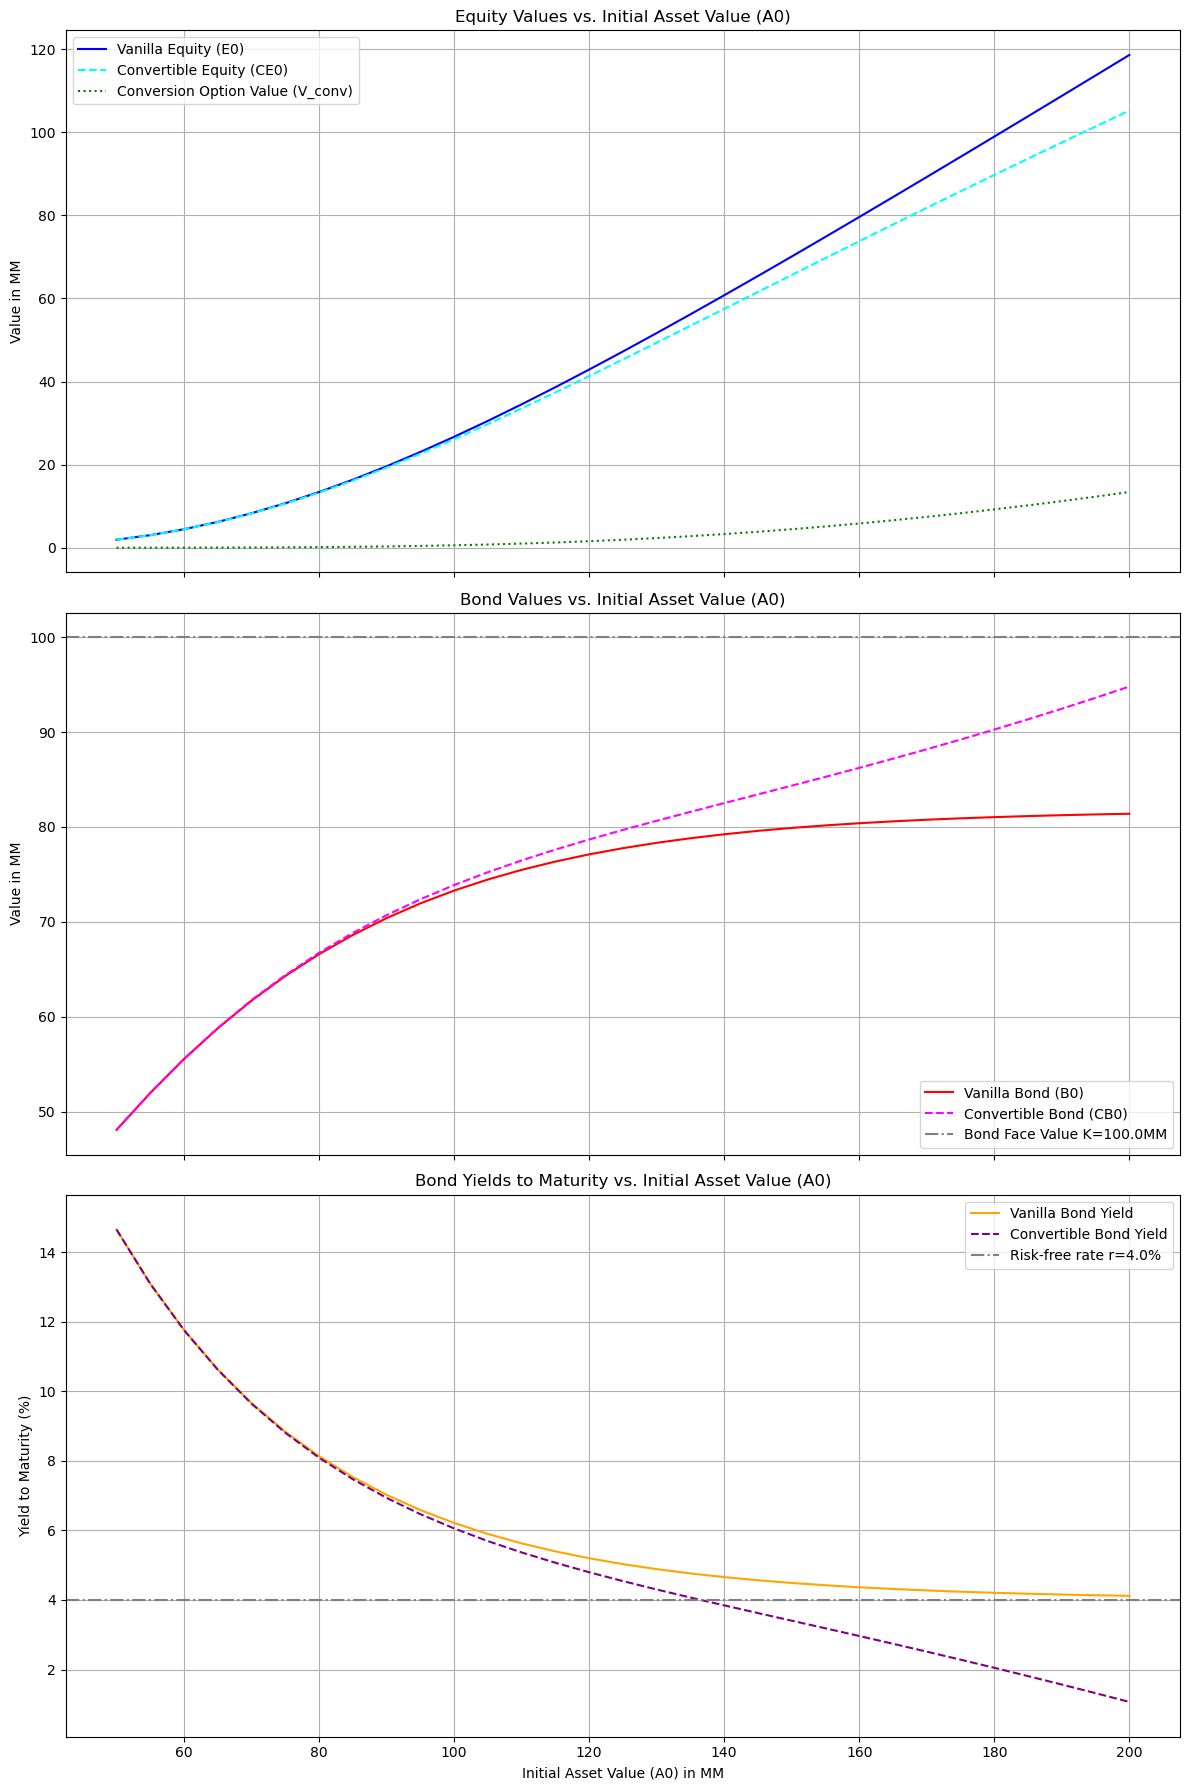

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plot Equity Values
axs[0].plot(A0_grid, E0_vals, label='Vanilla Equity (E0)', linestyle='-', color='blue')
axs[0].plot(A0_grid, CE0_vals, label='Convertible Equity (CE0)', linestyle='--', color='cyan')
axs[0].plot(A0_grid, V_conv_vals, label='Conversion Option Value (V_conv)', linestyle=':', color='green')
axs[0].set_title('Equity Values vs. Initial Asset Value (A0)')
axs[0].set_ylabel('Value in MM')
axs[0].legend()
axs[0].grid(True)

# Plot Bond Values
axs[1].plot(A0_grid, B0_vals, label='Vanilla Bond (B0)', linestyle='-', color='red')
axs[1].plot(A0_grid, CB0_vals, label='Convertible Bond (CB0)', linestyle='--', color='magenta')
axs[1].axhline(K_c, color='grey', linestyle='-.', label=f'Bond Face Value K={K_c}MM')
axs[1].set_title('Bond Values vs. Initial Asset Value (A0)')
axs[1].set_ylabel('Value in MM')
axs[1].legend()
axs[1].grid(True)

# Plot Bond Yields
axs[2].plot(A0_grid, yield_B0_vals, label='Vanilla Bond Yield', linestyle='-', color='orange')
axs[2].plot(A0_grid, yield_CB0_vals, label='Convertible Bond Yield', linestyle='--', color='purple')
axs[2].axhline(r_c*100, color='grey', linestyle='-.', label=f'Risk-free rate r={r_c*100:.1f}%')
axs[2].set_title('Bond Yields to Maturity vs. Initial Asset Value (A0)')
axs[2].set_xlabel('Initial Asset Value (A0) in MM')
axs[2].set_ylabel('Yield to Maturity (%)')
axs[2].legend()
axs[2].grid(True)

valid_yields_B0 = [y for y in yield_B0_vals if not np.isnan(y)]
valid_yields_CB0 = [y for y in yield_CB0_vals if not np.isnan(y)]
all_valid_yields = valid_yields_B0 + valid_yields_CB0
if all_valid_yields:
    min_yield = min(all_valid_yields)
    max_yield = max(all_valid_yields)
    axs[2].set_ylim(min_yield - 1, max_yield + 1)


plt.tight_layout()
plt.show()

-----------------------------------------------------------
# Problem 3: Correlated defaults: homogeneous issuers case
## Follow Lecture 7, "Correlated Defaults"
We are analyzing a pool consisting of n = 100 equally weighted credit issuers with $100 total face notional. Our investment time horizon is T = 5 years.

The pool is homogenous, and each issuer has:
1. a flat hazard rate h = 12%,
2. a constant recovery rate given default of R of 40% and
3. a correlation $\rho$ to the systematic (market) factor.

In [17]:
n_issuers = 100
total_notional = 100.0 
time_horizon_T = 5.0  
hazard_rate_h = 0.12 
recovery_rate_R = 0.40 
notional_per_issuer = total_notional / n_issuers

## a. Expected pool loss to time T

Compute the expected loss in the pool until time T.

In [18]:
sp_issuer = np.exp(-hazard_rate_h * time_horizon_T)
dp_issuer = 1 - sp_issuer

lgd_per_issuer = notional_per_issuer * (1 - recovery_rate_R)

el_per_issuer = dp_issuer * lgd_per_issuer
expected_pool_loss = n_issuers * el_per_issuer

In [19]:
print(f"Unconditional Survival Probability (SP) for one issuer: {sp_issuer:.4f}")
print(f"Unconditional Default Probability (DP) for one issuer: {dp_issuer:.4f}")
print(f"Notional per issuer: {notional_per_issuer:.2f}")
print(f"LGD per issuer: {lgd_per_issuer:.2f}")
print(f"Expected Loss per issuer: {el_per_issuer:.4f}")
print(f"Expected Pool Loss to time T: {expected_pool_loss:.4f}")

Unconditional Survival Probability (SP) for one issuer: 0.5488
Unconditional Default Probability (DP) for one issuer: 0.4512
Notional per issuer: 1.00
LGD per issuer: 0.60
Expected Loss per issuer: 0.2707
Expected Pool Loss to time T: 27.0713


## b. Counting the number of issuer defaults until time T

Write a function that computes the probability of exactly k defaults until time T. 

Use Lecture 7 Section "Correlated defaults" as a reference. 
For the numerical integration, you can use and quad from scipy.integrate (or similar).

$\mathbb{P}\left[L_{T}=k\cdot\frac{\left(1-R\right)}{n}\right]=\mathbb{P}\left[\sum_{i=1}^{n}\mathbb{I}_{\{\tau_{i}\leq T\}}=k\right]=\mathbb{\int_{-\infty}^{\infty}}{n \choose k}\cdot\left(1-p_{x}\right)^{k}\cdot p_{x}^{n-k}\cdot\varphi\left(x\right)dx$

$p_{x}^{i}=\mathbb{P}\left[Z^{i}<\frac{d_{-}^{i}-\rho_{i}\cdot x}{\sqrt{1-\rho_{i}^{2}}}\right]=\Phi\left(\frac{d_{-}^{i}-\rho_{i}\cdot x}{\sqrt{1-\rho_{i}^{2}}}\right)$

$p^{i}=\Phi\left(d_{-}^{i}\right), \forall i = 1..n$

In [20]:
d_minus = norm.ppf(sp_issuer) 

def prob_k_defaults_integrand(x, k, n, d_m, rho, sqrt_1_minus_rho_sq):
    if rho == 0:
        p_x = sp_issuer
    elif sqrt_1_minus_rho_sq == 0: 
        arg = (d_m - rho * x) / (1e-9) #
        p_x = norm.cdf(arg)

    else:
        arg = (d_m - rho * x) / sqrt_1_minus_rho_sq
        p_x = norm.cdf(arg) 

    prob_cond_survival = p_x
    prob_cond_default = 1.0 - prob_cond_survival

    prob_cond_survival = np.clip(prob_cond_survival, 1e-12, 1.0 - 1e-12)
    prob_cond_default = np.clip(prob_cond_default, 1e-12, 1.0 - 1e-12)

    binomial_coeff = comb(n, k)
    prob_k_defaults_given_x = binomial_coeff * (prob_cond_default**k) * (prob_cond_survival**(n-k))
    
    return prob_k_defaults_given_x * norm.pdf(x) 

def probability_of_k_defaults(k, n, T, h, rho_corr):
    sp = np.exp(-h * T)
    d_m = norm.ppf(sp)

    if not (0 <= rho_corr < 1.0):
         if rho_corr == 1.0: 
            if k == 0: 
                return norm.cdf(d_m)
            elif k == n: 
                return 1.0 - norm.cdf(d_m)
            else: 
                return 0.0
         elif rho_corr == 0: 
             dp = 1.0 - sp
             return comb(n,k) * (dp**k) * (sp**(n-k))

    sqrt_1_minus_rho_sq_val = np.sqrt(1.0 - rho_corr**2)
    if sqrt_1_minus_rho_sq_val == 0 and rho_corr != 1.0 and rho_corr != -1.0 : 
        print(f"Warning: sqrt(1-rho^2) is zero for rho={rho_corr}")
        if rho_corr > 0.999999: return probability_of_k_defaults(k,n,T,h,1.0)

    integral_result, integral_error = quad(
        prob_k_defaults_integrand,
        -8, 
        8,   
        args=(k, n, d_m, rho_corr, sqrt_1_minus_rho_sq_val)
    )
    
    return integral_result

In [21]:
k_example = 10 
rho_example = 0.2
prob_10_defaults = probability_of_k_defaults(k_example, n_issuers, time_horizon_T, hazard_rate_h, rho_example)

print(f"Probability of exactly {k_example} defaults with rho={rho_example*100}%: {prob_10_defaults:.6e}")
prob_10_defaults_rho0_integral = probability_of_k_defaults(k_example, n_issuers, time_horizon_T, hazard_rate_h, 0.0)
prob_10_defaults_rho0_binomial = comb(n_issuers, k_example) * (dp_issuer**k_example) * (sp_issuer**(n_issuers-k_example))
print(f"For rho=0: P({k_example} defaults) via integral = {prob_10_defaults_rho0_integral:.6e}")
print(f"For rho=0: P({k_example} defaults) via binomial = {prob_10_defaults_rho0_binomial:.6e}")

Probability of exactly 10 defaults with rho=20.0%: 4.189889e-06
For rho=0: P(10 defaults) via integral = 2.137872e-14
For rho=0: P(10 defaults) via binomial = 2.137872e-14


## c. Compute the distribution of number of defaults

Generate and plot the distribution and cumulative distribution of number of defaults.

Use a $\rho$ grid: [rho from 0% to 90% in steps of 10%] for plotting (10 lines total).

Comment on the results.

In [22]:
rho_grid = np.arange(0.0, 0.91, 0.10) 
num_defaults_range = np.arange(0, n_issuers + 1)

pmf_defaults = {} 
cdf_defaults = {} #

for rho_val in rho_grid:
    current_pmf = np.array([probability_of_k_defaults(k, n_issuers, time_horizon_T, hazard_rate_h, rho_val) for k in num_defaults_range])
    current_cdf = np.cumsum(current_pmf)
    
    current_pmf /= np.sum(current_pmf)
    current_cdf /= current_cdf[-1] 

    pmf_defaults[rho_val] = current_pmf
    cdf_defaults[rho_val] = current_cdf

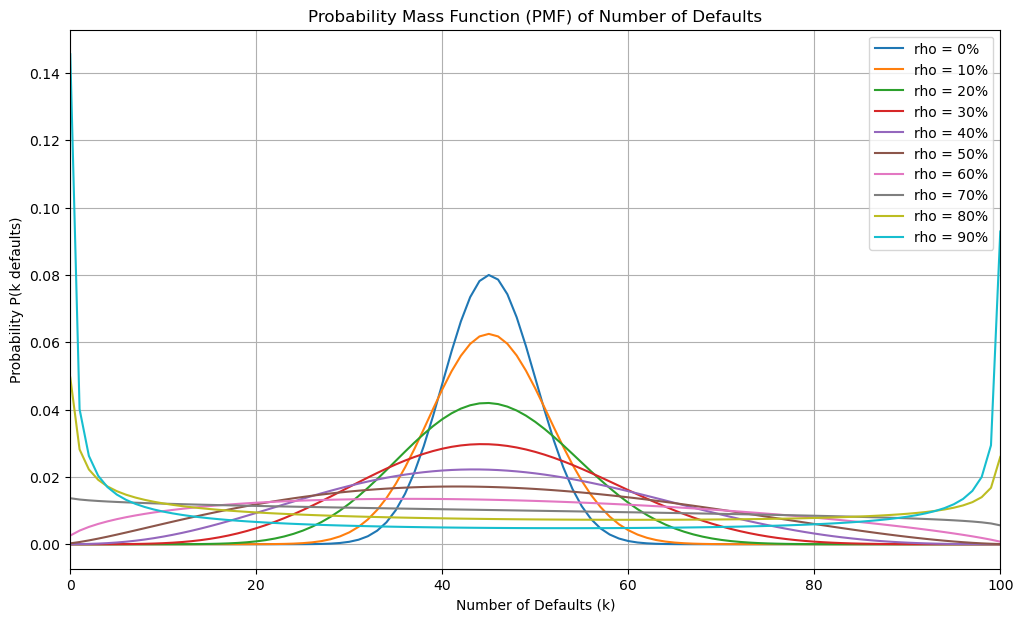

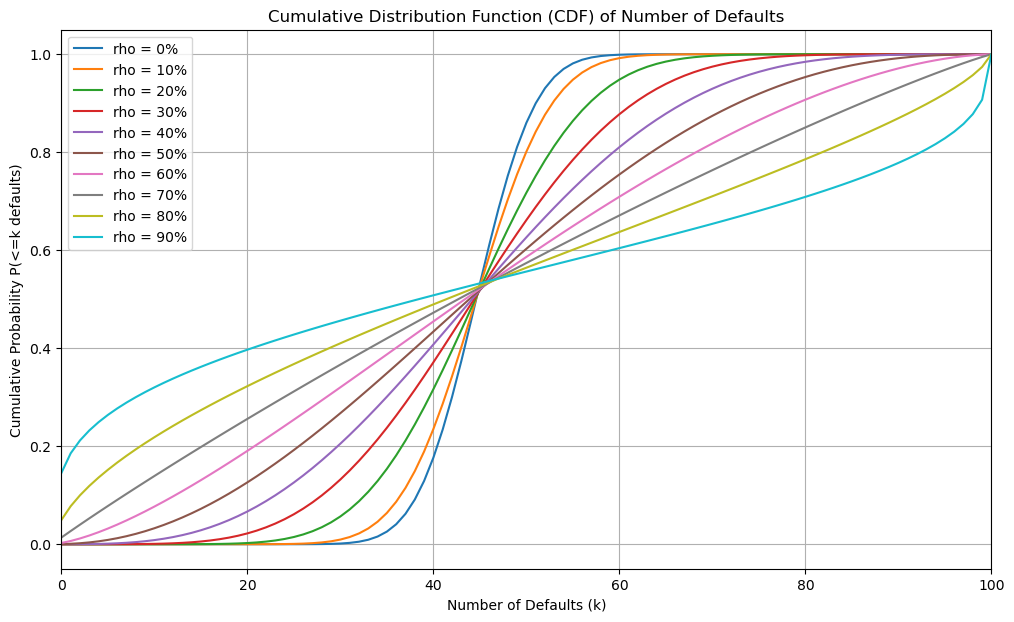

In [23]:
# Plotting PDF
plt.figure(figsize=(12, 7))
for rho_val in rho_grid:
    plt.plot(num_defaults_range, pmf_defaults[rho_val], label=f'rho = {rho_val*100:.0f}%')
plt.title('Probability Mass Function (PMF) of Number of Defaults')
plt.xlabel('Number of Defaults (k)')
plt.ylabel('Probability P(k defaults)')
plt.legend()
plt.grid(True)
plt.xlim(0, n_issuers) 
plt.show()

# Plotting CDF
plt.figure(figsize=(12, 7))
for rho_val in rho_grid:
    plt.plot(num_defaults_range, cdf_defaults[rho_val], label=f'rho = {rho_val*100:.0f}%')
plt.title('Cumulative Distribution Function (CDF) of Number of Defaults')
plt.xlabel('Number of Defaults (k)')
plt.ylabel('Cumulative Probability P(<=k defaults)')
plt.legend()
plt.grid(True)
plt.xlim(0, n_issuers)
plt.show()

#### PMF Behavior 
- ρ = 0%  
  - Sharp peak at $k = Np = 50\$, rapid decay in both tails  
  - Implies near-independent defaults.
  - Tail events (very few or very many defaults) are extremely unlikely

- ρ = 10–30%  
  - Peak flattens, wings thicken  
  - Modest default correlation → higher clustering risk.
  - Average outcomes less certain

- ρ = 40–60%  
  - Almost uniform mass over mid-range $k$ (20–80)  
  - Large dispersion.
  - VaR bands widen dramatically

- ρ = 70–90%  
  - Bimodal spikes at $k\approx0$ and $k\approx N$
  - Portfolio behaves like a binary “all-or-nothing” bet—systemic crisis vs. calm

#### CDF Insights 
- All curves cross at $P(K\le50)\approx50\%$ (since $\mathbb{E}[K]=Np$ is fixed)  
- Low ρ (steep S-curve):  
  - Rapid transition from near 0 to near 1 around the mean  
- High ρ (flattened S-curve / near-linear):  
  - Wide spread of probabilities across $k$
  - Extreme events dominate

#### Implications
- Tail Risk increases as ρ increases:  
  - 99% VaR jumps from just above 50 defaults (low ρ) to nearly 100 (high ρ)  
  - Expected Shortfall similarly explodes

- Systemic-Event Modeling:  
  - High correlation regimes capture “all-or-nothing” crisis dynamics  
  - Essential for CDO tranche pricing and stress testing

- Hedging & Diversification:  
  - True diversification requires low default correlation  
  - Hedge correlation risk via index tranches or correlation swaps

## d. Compute the Mean and Standard Deviation of Pool Losses, for all correlation coefficients $\rho$ in the grid

Calculate, display and plot the Mean and Standard Deviation of pool losses for each $\rho$ in the grid.

Comment on the results.

In [24]:
mean_num_defaults_list = []
std_dev_num_defaults_list = []
mean_pool_loss_list = []
std_dev_pool_loss_list = []
records = []

for rho_val in rho_grid:
    current_pmf = pmf_defaults[rho_val]

    mean_nd = np.sum(num_defaults_range * current_pmf)
    mean_num_defaults_list.append(mean_nd)
    
    mean_l = mean_nd * lgd_per_issuer
    mean_pool_loss_list.append(mean_l)
    
    e_nd_sq = np.sum((num_defaults_range**2) * current_pmf)
    var_nd = e_nd_sq - (mean_nd**2)
    std_dev_nd = np.sqrt(var_nd)
    std_dev_num_defaults_list.append(std_dev_nd)
    
    std_dev_l = std_dev_nd * lgd_per_issuer
    std_dev_pool_loss_list.append(std_dev_l)
    records.append({"rho": rho_val*100, 
                    "E(N_D)": mean_nd, 
                    "Std(N_D)": std_dev_nd, 
                    "E(L_pool)": mean_l, 
                    "StdDev(L_pool)": std_dev_l}
                  )

display(pd.DataFrame(records))

,rho,E(N_D),Std(N_D),E(L_pool),StdDev(L_pool)
0,0.0,45.118836,4.976117,27.071302,2.985670
1,10.0,45.118836,6.346985,27.071302,3.808191
2,20.0,45.118836,9.320984,27.071302,5.592590
3,30.0,45.118836,12.834718,27.071302,7.700831
4,40.0,45.118836,16.566318,27.071302,9.939791
5,50.0,45.118836,20.434915,27.071302,12.260949
6,60.0,45.118836,24.446293,27.071302,14.667776
7,70.0,45.118836,28.667951,27.071302,17.200771
8,80.0,45.118836,33.264265,27.071302,19.958559
9,90.0,45.118836,38.684146,27.071302,23.210487


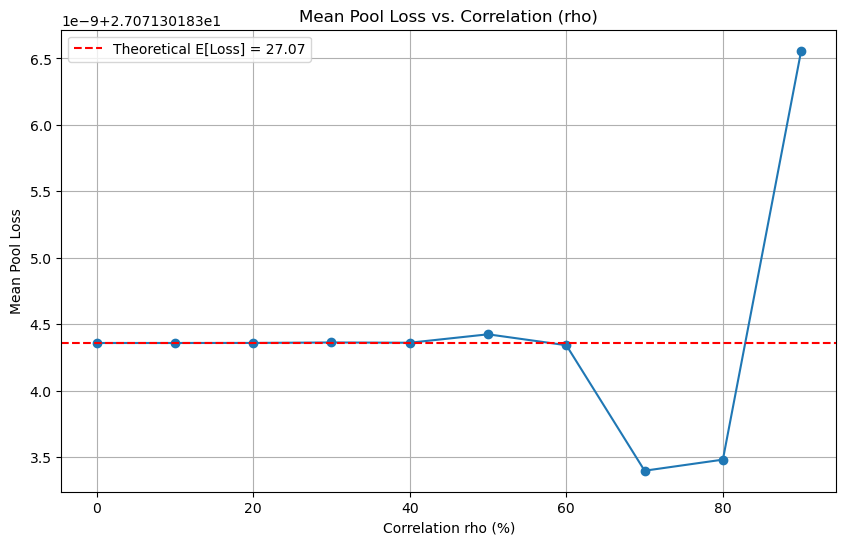

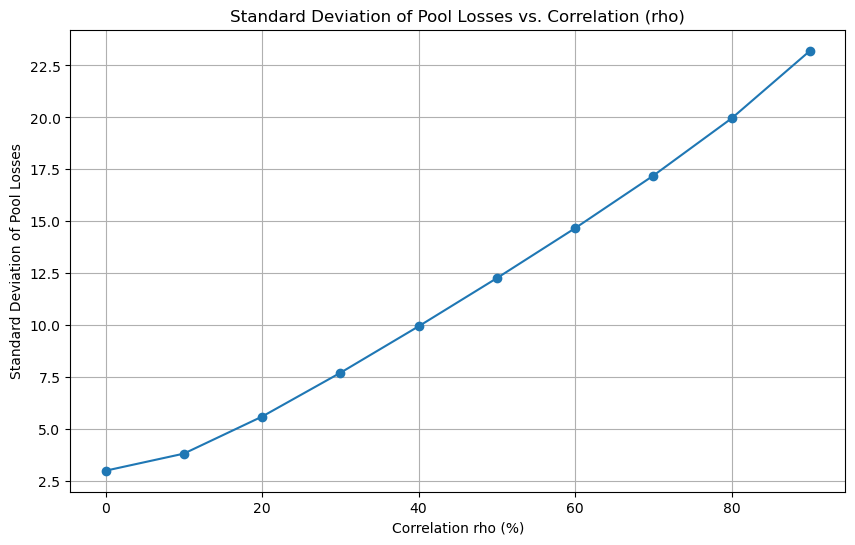

In [25]:
# Plotting Mean Pool Loss vs. Rho
plt.figure(figsize=(10, 6))
plt.plot(rho_grid * 100, mean_pool_loss_list, marker='o')
plt.title('Mean Pool Loss vs. Correlation (rho)')
plt.xlabel('Correlation rho (%)')
plt.ylabel('Mean Pool Loss')
plt.axhline(expected_pool_loss, color='r', linestyle='--', label=f'Theoretical E[Loss] = {expected_pool_loss:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Std Dev of Pool Losses vs. Rho
plt.figure(figsize=(10, 6))
plt.plot(rho_grid * 100, std_dev_pool_loss_list, marker='o')
plt.title('Standard Deviation of Pool Losses vs. Correlation (rho)')
plt.xlabel('Correlation rho (%)')
plt.ylabel('Standard Deviation of Pool Losses')
plt.grid(True)
plt.show()

- Expected Number of Defaults $E[N_D]$
  - $Constant at ~45.12$ for all ρ (since marginal PD and portfolio size are fixed)  
  - Implies correlation does $not$ change average defaults, only dispersion

- Std Dev of Defaults $\sigma(N_D)$  
  - Rises steeply from ~3.0 at ρ=0% to ~38.7 at ρ=90%  
  - Low ρ implies a tight clustering around the mean.
  - High ρ implies huge spread, “all-or-nothing” default swings

- Expected Pool Loss $E[L_{\rm pool}]$  
  - Constant at ~27.07 (loss = LGD × $E[N_D]$
  - Confirms average loss unaffected by default correlation

- Std Dev of Pool Loss $\sigma(L_{\rm pool})$
  - Increases in lockstep with $\sigma(N_D)$: from ~2.99 to ~23.21  
  - Higher correlation ⇒ far greater uncertainty in loss outcomes

#### Implications

- Average‐loss metrics (EL) are insufficient - they hide the explosive rise in tail‐risk as ρ increases.  
- Economic Capital & VaR must account for correlation‐driven dispersion as capital reserves need to grow dramatically under higher ρ.  
- Hedging Strategy:  
  - At low ρ, simple diversification suffices.  
  - At high ρ, must layer in tail‐risk hedges (e.g. CDS index tranches, correlation swaps) to guard against extreme loss variability. 

------------------------------------------------------------------
# Problem 4: Derivation of fixed rate bond PVs and DV01s in `sympy`

Starting from the fair value formula for risky fixed rate bonds in the `flat yield model`, you will derive the formulas for
* Zero coupon bonds (principal payment only, no coupons) and
* "Interest Only" / IO bonds (coupon payments only, no principal payment)

Assume T+0 settlement and zero accrued.

### Flat Yield Model Parameters
* bond face value of 100%
* bond maturity T (in years),
* semi-annual coupon c,
* flat yield y

According to formula [5] in Lecture 1, the bond present value is given by:

\begin{align}
BondPV=B(0,T,c,y)
\end{align}

\begin{align}
=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}}+e^{-T\cdot y}
\end{align}

\begin{align}
= 1+\frac{\frac{c}{2}-\left( e^{\frac{y}{2}}-1 \right)}{e^{\frac{y}{2}}-1 } \cdot \left(1-e^{-T\cdot y}\right)
\end{align}


The example code below explains how to implement the present value function for the generic fixed rate bond.

It uses the 'sympy' library (symbolic mathematics) to translate mathematical formulas into a sympy symbolic equation, as described in the solution to Homework 3, Problem 2.

The sympy symbolic equation is converted into a Python function via sympy.lambdify.

The function `plot_bond_function_surface(bond_func, 'Plot Title')` plots the Python bond function on a "yield x maturity" 2D discretization grid:

* in yield space: [y from 0% to 10% in steps of 0.5%] and 
* in time-to-maturity space: [T from 1Y to 20Y in steps of 1Y].

We assume a bond coupon c of 5% for plotting purposes.

In [26]:
def plot_bond_function_surface(bond_func_lamda, title_str, coupon_for_plot=0.05, is_dv01=False):
    y_plot_grid = np.arange(0.001, 0.1001, 0.005)
    T_plot_grid = np.arange(1.0, 20.0 + 1.0, 1.0)  

    X_plot, Y_plot = np.meshgrid(y_plot_grid, T_plot_grid)
    Z_plot = np.zeros_like(X_plot)

    for i in range(len(T_plot_grid)):
        for j in range(len(y_plot_grid)):
            try:
                Z_plot[i,j] = bond_func_lamda(coupon_for_plot, Y_plot[i,j], X_plot[i,j])
            except TypeError: 
                Z_plot[i,j] = bond_func_lamda(Y_plot[i,j], X_plot[i,j])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X_plot, Y_plot, Z_plot, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title_str)
    ax.set_xlabel('Bond Yield')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('DV01' if is_dv01 else 'Bond Metric Value')
    plt.show()

Analytic formula for bond_pv: (1 - exp(-T*y))*(c/2 - exp(y/2) + 1)/(exp(y/2) - 1) + 1


(1 - exp(-T*y))*(c/2 - exp(y/2) + 1)/(exp(y/2) - 1) + 1

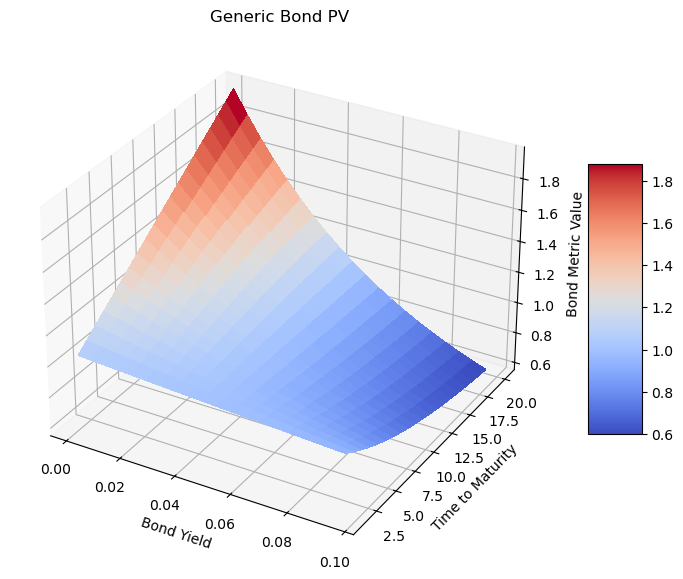

In [27]:
# define symbolic variables
t = sp.symbols('T')
c = sp.symbols('c')
y = sp.symbols('y')

# define symbolic equation for bond pv
bond_pv_eq =  1 + (c/2 -(sp.exp(y/2) - 1)) / (sp.exp(y/2) - 1) * (1 - sp.exp(-t*y))
print('Analytic formula for bond_pv:', bond_pv_eq)
display(bond_pv_eq)

# create function(y,T,y) from equation
bond_pv_func = sp.lambdify([c,t,y], bond_pv_eq)

# Plot the surface
plot_bond_function_surface(bond_pv_func, 'Generic Bond PV')

## a. Derive and plot the DV01 of a Fixed rate bond

Use the sympy "diff()" function to compute & display the derivative of the fixed rate bond PV with respect to the bond yield.

Plot the bond DV01 surface on the "yield x maturity" 2D discretization grid.


<IPython.core.display.Math object>

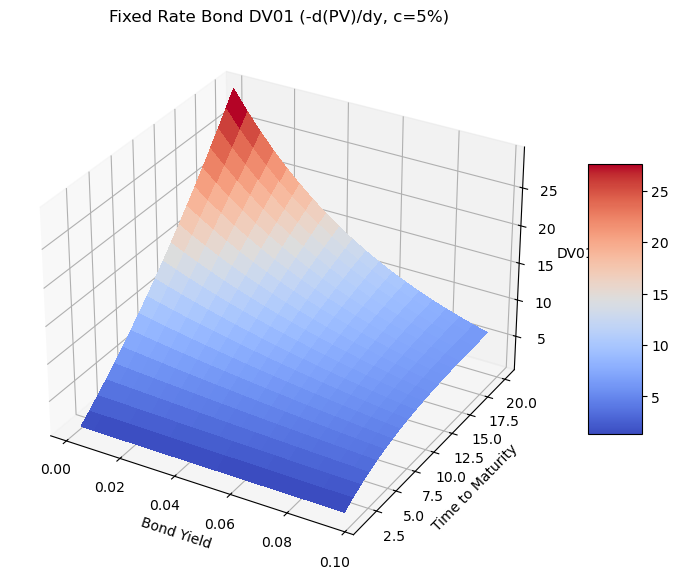

In [28]:
bond_pv_derivative_wrt_y = sp.diff(bond_pv_eq, y)

display(Math(f"\\frac{{\partial BondPV}}{{\partial y}} = {sp.latex(bond_pv_derivative_wrt_y)}"))

bond_pv_derivative_func_lambda = sp.lambdify([c, t, y], bond_pv_derivative_wrt_y, 'numpy')

def dv01_fixed_rate_bond_plot_func(c, T, y):
    return -bond_pv_derivative_func_lambda(c, T, y)

plot_bond_function_surface(dv01_fixed_rate_bond_plot_func, 'Fixed Rate Bond DV01 (-d(PV)/dy, c=5%)', is_dv01=True)

## b. Derive and plot the present value functions for a Zero Coupon bond.

Derive and display the analytic formula for a Zero Coupon bond PV.

Plot the Zero Coupon bond PV surface on the "yield x maturity" 2D discretization grid.

<IPython.core.display.Math object>

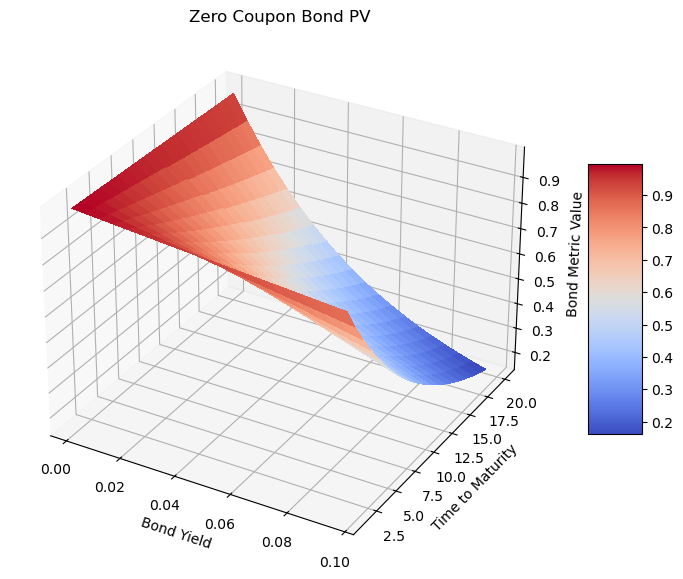

In [29]:
zc_bond_pv_eq = bond_pv_eq.subs(c, 0)
zc_bond_pv_eq_simplified = sp.simplify(zc_bond_pv_eq)

display(Math(f"PV_{{ZC}} = {sp.latex(zc_bond_pv_eq_simplified)}"))

zc_bond_pv_func_lambda_orig = sp.lambdify([t, y], zc_bond_pv_eq_simplified, 'numpy')

def zc_bond_pv_plot_func(c_dummy, T, y): 
    return zc_bond_pv_func_lambda_orig(T,y)

plot_bond_function_surface(zc_bond_pv_plot_func, 'Zero Coupon Bond PV')

## c. Derive and plot the DV01 of a Zero Coupon bond.

Use the sympy "diff()" function to compute & display the derivative of the Zero Coupon bond PV with respect to the bond yield.

Plot the Zero Coupon bond DV01 surface on the "yield x maturity" 2D discretization grid.


<IPython.core.display.Math object>

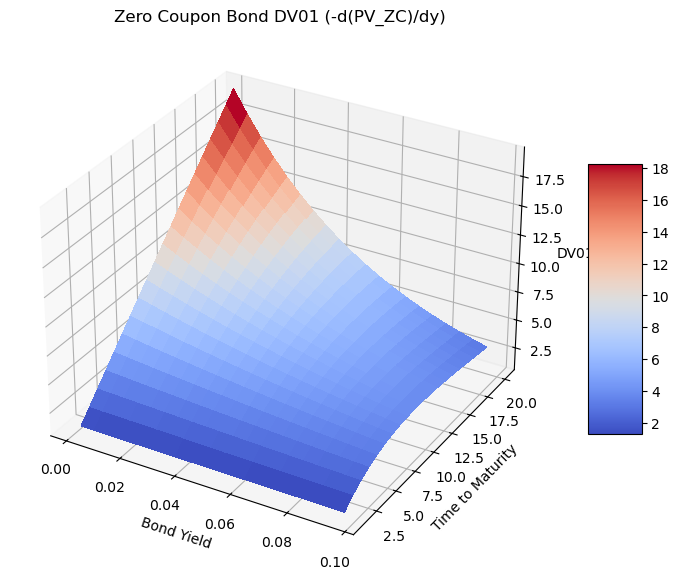

In [30]:
zc_bond_pv_derivative_wrt_y = sp.diff(zc_bond_pv_eq_simplified, y)
zc_bond_pv_derivative_wrt_y_simplified = sp.simplify(zc_bond_pv_derivative_wrt_y)

display(Math(f"\\frac{{\partial PV_{{ZC}}}}{{\partial y}} = {sp.latex(zc_bond_pv_derivative_wrt_y_simplified)}"))

zc_bond_pv_derivative_func_lambda = sp.lambdify([t, y], zc_bond_pv_derivative_wrt_y_simplified, 'numpy')

def dv01_zc_bond_plot_func(c_dummy, T, y):
    return -zc_bond_pv_derivative_func_lambda(T, y)

plot_bond_function_surface(dv01_zc_bond_plot_func, 'Zero Coupon Bond DV01 (-d(PV_ZC)/dy)', is_dv01=True)

## d. Derive and plot the present value function for an Interest Only bond.

Derive and display the analytic formula for an Interest Only bond PV.

Plot the Interest Only bond PV surface on the "yield x maturity" 2D discretization grid.

Keep in mind that any generic fixed rate bond can be decomposed into Zero Coupon and Interest Only components.

<IPython.core.display.Math object>

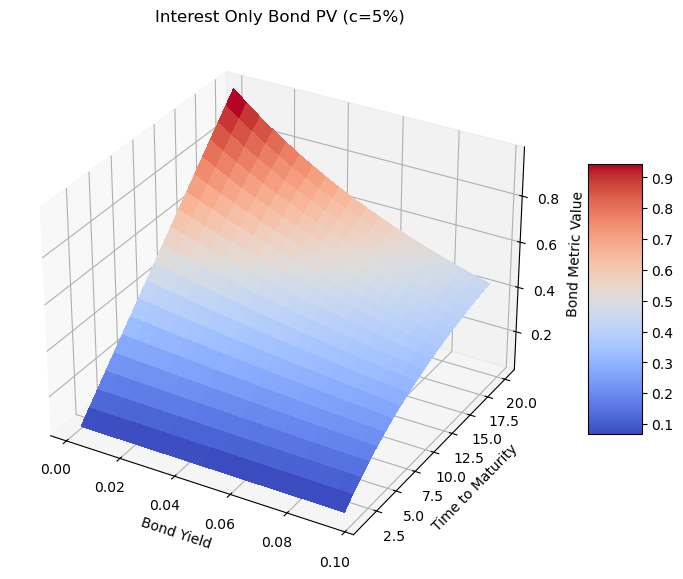

In [31]:
io_bond_pv_eq = bond_pv_eq - zc_bond_pv_eq_simplified 
io_bond_pv_eq_simplified = sp.simplify(io_bond_pv_eq)

display(Math(f"PV_{{IO}} = {sp.latex(io_bond_pv_eq_simplified)}"))

io_bond_pv_func_lambda = sp.lambdify([c, t, y], io_bond_pv_eq_simplified, 'numpy')

plot_bond_function_surface(io_bond_pv_func_lambda, 'Interest Only Bond PV (c=5%)')

## e. Derive and plot the DV01 of an Interest Only bond.

Use the sympy "diff()" function to compute and display the derivative of the Interest Only bond PV.

Plot the Interest Only bond DV01 surface on the "yield x maturity" 2D discretization grid.


<IPython.core.display.Math object>

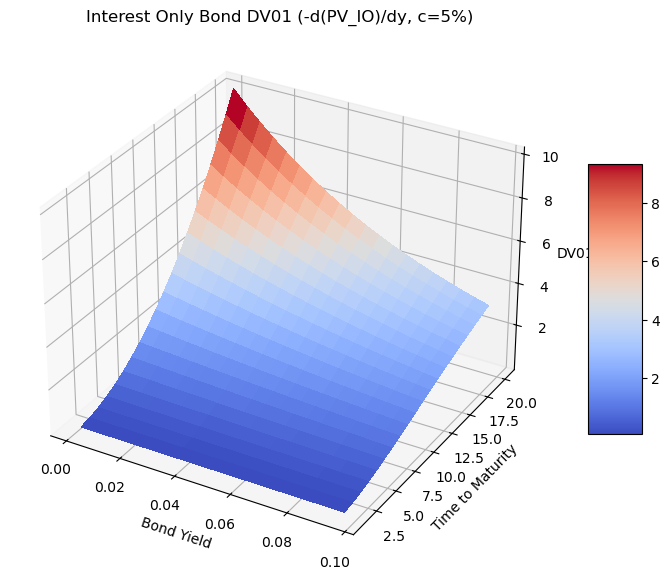

In [32]:
io_bond_pv_derivative_wrt_y = sp.diff(io_bond_pv_eq_simplified, y)
io_bond_pv_derivative_wrt_y_simplified = sp.simplify(io_bond_pv_derivative_wrt_y)

display(Math(f"\\frac{{\partial PV_{{IO}}}}{{\partial y}} = {sp.latex(io_bond_pv_derivative_wrt_y_simplified)}"))

io_bond_pv_derivative_func_lambda = sp.lambdify([c, t, y], io_bond_pv_derivative_wrt_y_simplified, 'numpy')

def dv01_io_bond_plot_func(c, T, y):
    return -io_bond_pv_derivative_func_lambda(c, T, y)

plot_bond_function_surface(dv01_io_bond_plot_func, 'Interest Only Bond DV01 (-d(PV_IO)/dy, c=5%)', is_dv01=True)

## f. For which bond coupon $c^*$ are the Interest Only PV and the Zero Coupon PV equal?
 
### Find the bond coupon $c^*$ satisfying:

\begin{align}
InterestOnlyPV(c^*, y,T) = ZeroCouponPV(y,T)
\end{align}

Display the formula for $c^*$.

In [33]:
c_star_sym = sp.symbols('c^*')
equation_to_solve = sp.Eq(io_bond_pv_eq_simplified.subs(c, c_star_sym), zc_bond_pv_eq_simplified)
c_star_solution = sp.solve(equation_to_solve, c_star_sym)

if c_star_solution:
    c_star_formula = c_star_solution[0]
    display(Math(f"c^* = {sp.latex(c_star_formula)}"))
else:
    print("Could not find a symbolic solution for c*.")

<IPython.core.display.Math object>